# Make Sure the ML Model Fitted Correctly

In [1]:
# Create a strategy using the trained model
# Backtest using timerange TRAINVAL, and pairs of trained model
# Make sure the profit graph is upwards (ofc coz we BT'ed in train and val date)

In [1]:
%load_ext autoreload
%autoreload 2
%env WANDB_SILENT=true

from pathlib import Path
from copy import deepcopy
import matplotlib.pyplot as plt
import pandas as pd
import quantstats as qs
import os
import logging
import sys
import nest_asyncio

nest_asyncio.apply()

while "freqtrade" not in os.listdir():
    os.chdir("..")
    if "freqtrade" in os.listdir():
        nest_asyncio.apply()
        logger = logging.getLogger("freqtrade.nbtools")
        handler = logging.StreamHandler(stream=sys.stdout)
        handler.setFormatter(logging.Formatter("%(name)s - %(message)s"))
        logger.addHandler(handler)
        logger.setLevel(logging.DEBUG)

# Freqtrade Imports
from freqtrade.optimize.optimize_reports import text_table_add_metrics
from freqtrade.nbtools.preset import ConfigPreset
from freqtrade.nbtools.backtest import backtest, DataLoader
from freqtrade.nbtools.remote_utils import load_lightning_container, get_lightning_artifact_ver
from freqtrade.nbtools.helper import parse_function_body
from freqtrade.nbtools import plotting, configs
from freqtrade.ml import lightning_utils

# Constants
PATH_MOUNT = Path.cwd().parent / "mount"
DATALOADER = DataLoader(max_n_datasets=5)

# Custom function
def string_templating(string: str, data: dict, strip_doublequotes=False):
    _string = deepcopy(string)
    """Replace [|key|] in string with data["key"] """
    for key, value in data.items():
        to_replace = "[|{}|]".format(key)
        if strip_doublequotes:
            to_replace = "\"[|{}|]\"".format(key)
        if to_replace not in string:
            raise Exception(f"Not found formatting with key '{key}'")
        _string = _string.replace(to_replace, str(value))
    return _string


def start_backtesting(strat_func, lightning_name: str, bt_type: str, version):
    PATH_LOCAL_DATADIR = PATH_MOUNT / "data"
    LIGHTNING_CONTAINER_NAME = lightning_name

    # TODO: Resolve "latest" to number version
    if version == "latest":
        version = get_lightning_artifact_ver(LIGHTNING_CONTAINER_NAME, LIGHTNING_CONTAINER_NAME)
        print(f"You are using LATEST ({version}) of '{LIGHTNING_CONTAINER_NAME}'")

    lightning_container = load_lightning_container(LIGHTNING_CONTAINER_NAME, LIGHTNING_CONTAINER_NAME, version=version)
    
    if bt_type == "val":
        timerange = lightning_utils.get_timerange_trainval(lightning_container)
    elif bt_type == "opt":
        timerange = lightning_utils.get_timerange_opt(lightning_container)
    elif bt_type == "test":
        timerange = lightning_utils.get_timerange_test(lightning_container)
    else:
        raise Exception(f"Unknown BT type: {bt_type}")
    
    preset = ConfigPreset(
        name=f"ml_{bt_type}_{LIGHTNING_CONTAINER_NAME}",
        config_dict = configs.DEFAULT,
        path_data=PATH_LOCAL_DATADIR,
        timerange=timerange
    )
    preset.overwrite_config(pairs=lightning_container.config.pairs)

    strategy_code = string_templating(
        parse_function_body(strat_func),
        data={
            "LIGHTNING_CONTAINER_NAME": LIGHTNING_CONTAINER_NAME,
            "VERSION": version
        }
    )
    stats, summary = backtest(preset, strategy_code, dataloader=DATALOADER)
    return stats, summary, preset

env: WANDB_SILENT=true
freqtrade.nbtools.backtest - Initialized DataLoader with 5 max datas.


# Model Validation

In [10]:
"""
This strategy will backtested in Train and Validation date.
To make sure the model was fitted correctly, you need to know that you model is predicting accurately in this date.
Create the strategy that BUYS when the ML Model predicts the future is going to UP, and do the same for the sell.
The strategy doesn't need to be trend following, but the final backtest results must profitable steadily.

TIP: High threshold no trendline |OR| Low threshold with trendline
"""

def val_strategy():
    """ Start Strategy Code """
    from freqtrade.nbtools.strategy import INbStrategy
    from freqtrade.nbtools.remote_utils import load_lightning_container
    from freqtrade.ml.container import LightningContainer
    from pandas import DataFrame
    from functools import reduce
    import numpy as np  # noqa
    import pandas as pd  # noqa
    import talib.abstract as ta
    
    LIGHTNING_CONTAINER_NAME = "[|LIGHTNING_CONTAINER_NAME|]"
    lightning_container = load_lightning_container(LIGHTNING_CONTAINER_NAME, LIGHTNING_CONTAINER_NAME, version="[|VERSION|]")        
    tp = str(int(lightning_container.config.timeframe.replace("m", "")) * lightning_container.config.num_future_candles)

    class NotebookStrategy(INbStrategy):
        # These attributes are REQUIRED!
        timeframe = lightning_container.config.timeframe
        minimal_roi = {tp: -99}
        stoploss = -0.99
        startup_candle_count: int = 500
                    
        def populate_indicators(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            num_classes = lightning_container.config.num_classification_classes
            dataframe = lightning_container.predict(dataframe)
            dataframe["argmax_ml"] = dataframe[[f"ml_{x}"for x in range(num_classes)]].idxmax(axis=1)
            return dataframe

        def populate_buy_trend(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            conditions = [
                dataframe["argmax_ml"] == "ml_4",
                dataframe['volume'] > 0,
            ]
            
            dataframe.loc[reduce(lambda x, y: x & y, conditions), 'buy'] = 1
                        
            return dataframe

        def populate_sell_trend(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            num_candles_forward = lightning_container.config.num_future_candles
            conditions = [
                dataframe['buy'].shift(num_candles_forward) == 1,
                dataframe['volume'] > 0,
            ]
            
            dataframe.loc[reduce(lambda x, y: x & y, conditions), 'sell'] = 1
            
            # self.print_once(dataframe.info(), "info_df")
            # self.print_once(dataframe.describe(), "describe_df")
            # self.print_once(dataframe, "populate_buy_sell")
            
            return dataframe
    """ End Strategy Code """

You are using LATEST (v1) of '15n30-catboost_l3'
freqtrade.nbtools.remote_utils - Load LightningContainer version 'v1' of project: '15n30-catboost_l3' - asset_name: '15n30-catboost_l3'.
freqtrade.nbtools.preset.base_preset - Overwriting pairs (from 0 to 61 pairs)
freqtrade.nbtools.preset.base_preset - Overwriting pairs (from 0 to 61 pairs)
freqtrade.nbtools.preset.base_preset - Setting config for ml_val_15n30-catboost_l3 ...
freqtrade.nbtools.preset.base_preset - Setting arg `datadir` to c:\CS\Python\crypto-collection\freqtrade\mount\data\binance
freqtrade.nbtools.preset.base_preset - Setting arg `timerange` to 20160101-20210301
freqtrade.nbtools.helper - Strategy using minimal_roi: {'30': -99}
freqtrade.nbtools.helper - Strategy using timeframe: 15m
freqtrade.nbtools.helper - Strategy using stoploss: -0.99
freqtrade.nbtools.helper - Strategy using trailing_stop: False
freqtrade.nbtools.helper - Strategy using trailing_stop_positive_offset: 0.0
freqtrade.nbtools.helper - Strategy using

Populating Indicators:   0%|          | 0/60 [00:00<?, ?it/s]

freqtrade.nbtools.helper - "Backtest" executed in 62.89s
freqtrade.nbtools.backtest - Logging preset...
freqtrade.nbtools.backtest - [LOG PRESET OFFLINE SUCCESS]
freqtrade.nbtools.backtest - Sync preset with name: ml_val_15n30-catboost_l3__backtest-2021-09-03_13-31-42
freqtrade.nbtools.backtest - with random name: lazy-vector-keyboard
freqtrade.nbtools.backtest - [WANDB LOG PRESET CONTINUES IN BACKGROUND]
freqtrade.nbtools.helper - "Whole Backtesting Process (Backtest + Log)" executed in 68.78s


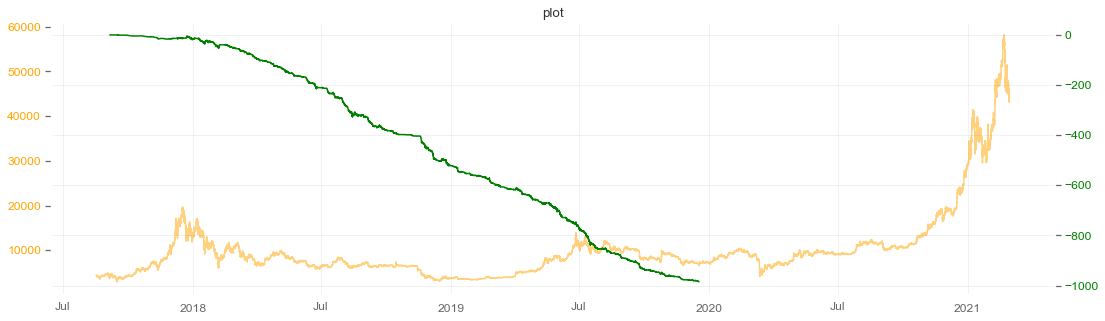

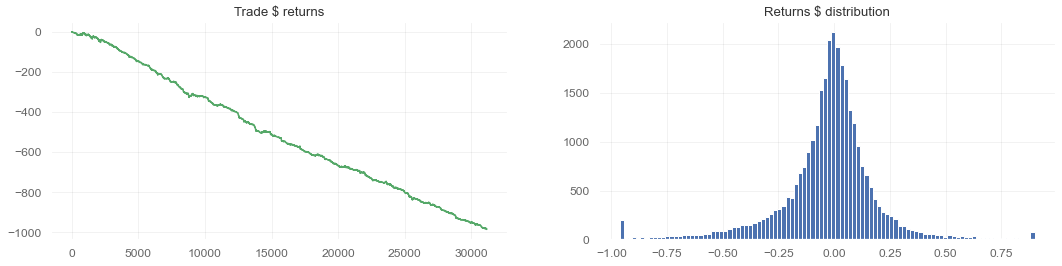

,Portfolio Summary
Trades,31150
Avg. Stake Amount,15.0
Number of Pairs,38
Min Balance,-985.76
Max Balance,0.75
Final Balance,-985.76
-,-
Wins,14547
Loses,16603
Win Rate,47.0%


freqtrade.nbtools.remote_utils - Adding new row to table...
freqtrade.nbtools.remote_utils - Columns are not identical.
freqtrade.nbtools.remote_utils - New columns    : []
freqtrade.nbtools.remote_utils - Removed columns: ['daily_profit', 'pairlist']
freqtrade.nbtools.remote_utils - Inserting 'None' to removed columns
freqtrade.nbtools.backtest - ===============================
freqtrade.nbtools.backtest - |  'ml_val_15n30-catboost_l3__backtest-2021-09-03_13-31-42'
freqtrade.nbtools.backtest - |  WANDB LOG PRESET FINISHED  
freqtrade.nbtools.backtest - ===============================


In [11]:
MODEL_NAME = "15n30-catboost_l3"
MODEL_VER = "latest"

stats, summary, preset = start_backtesting(val_strategy, MODEL_NAME, "val", version=MODEL_VER)
trades = pd.DataFrame(stats["strategy"]["NotebookStrategy"]["trades"])
plotting.plot_profits_timerange(trades, timerange=preset.timerange, path_mount=PATH_MOUNT)

# Model x Strategy Optimization

In [12]:
""" 
In this phase, tinker your strategy until you get the "Sweet Spot"!
"""

def opt_strategy():
    """ Start Strategy Code """
    from freqtrade.nbtools.strategy import INbStrategy
    from freqtrade.nbtools.remote_utils import load_lightning_container
    from freqtrade.ml.container import LightningContainer
    from pandas import DataFrame
    from functools import reduce
    import numpy as np  # noqa
    import pandas as pd  # noqa
    import talib.abstract as ta
    
    LIGHTNING_CONTAINER_NAME = "[|LIGHTNING_CONTAINER_NAME|]"
    lightning_container = load_lightning_container(LIGHTNING_CONTAINER_NAME, LIGHTNING_CONTAINER_NAME, version="[|VERSION|]")        
    tp = str(int(lightning_container.config.timeframe.replace("m", "")) * lightning_container.config.num_future_candles)
    
    class NotebookStrategy(INbStrategy):
        # These attributes are REQUIRED!
        timeframe = lightning_container.config.timeframe
        minimal_roi = {tp: -99}
        stoploss = -0.99
        startup_candle_count: int = 500
                    
        def populate_indicators(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            dataframe["ema"] = ta.EMA(dataframe, timeperiod=200)
            dataframe = lightning_container.predict(dataframe)
            
            num_classes = 5
            dataframe["argmax_ml"] = dataframe[[f"ml_{x}"for x in range(num_classes)]].idxmax(axis=1)
            return dataframe

        def populate_buy_trend(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            conditions = [
                # dataframe['close'] > dataframe['ema'],
                dataframe['argmax_ml'] == "ml_4",
                dataframe['ml_4'] > 0.65,
                dataframe['volume'] > 0,
            ]
            
            dataframe.loc[reduce(lambda x, y: x & y, conditions), 'buy'] = 1
            return dataframe

        def populate_sell_trend(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            num_candles_forward = lightning_container.config.num_future_candles
            conditions = [
                dataframe['buy'].shift(num_candles_forward) == 1,
                dataframe['volume'] > 0,
            ]
            
            dataframe.loc[reduce(lambda x, y: x & y, conditions), 'sell'] = 1
            return dataframe
    """ End Strategy Code """

You are using LATEST (v1) of '15n30-catboost_l3'
freqtrade.nbtools.preset.base_preset - Overwriting pairs (from 0 to 61 pairs)
freqtrade.nbtools.preset.base_preset - Overwriting pairs (from 0 to 61 pairs)
freqtrade.nbtools.preset.base_preset - Setting config for ml_opt_15n30-catboost_l3 ...
freqtrade.nbtools.preset.base_preset - Setting arg `datadir` to c:\CS\Python\crypto-collection\freqtrade\mount\data\binance
freqtrade.nbtools.preset.base_preset - Setting arg `timerange` to 20210302-20210701
freqtrade.nbtools.helper - Strategy using minimal_roi: {'30': -99}
freqtrade.nbtools.helper - Strategy using timeframe: 15m
freqtrade.nbtools.helper - Strategy using stoploss: -0.99
freqtrade.nbtools.helper - Strategy using trailing_stop: False
freqtrade.nbtools.helper - Strategy using trailing_stop_positive_offset: 0.0
freqtrade.nbtools.helper - Strategy using trailing_only_offset_is_reached: False
freqtrade.nbtools.helper - Strategy using use_custom_stoploss: False
freqtrade.nbtools.helper - S

Populating Indicators:   0%|          | 0/60 [00:00<?, ?it/s]

freqtrade.nbtools.helper - "Backtest" executed in 27.09s
freqtrade.nbtools.backtest - Logging preset...
freqtrade.nbtools.backtest - [LOG PRESET OFFLINE SUCCESS]
freqtrade.nbtools.backtest - Sync preset with name: ml_opt_15n30-catboost_l3__backtest-2021-09-03_13-33-22
freqtrade.nbtools.backtest - with random name: introvert-spiderman-desktop
freqtrade.nbtools.backtest - [WANDB LOG PRESET CONTINUES IN BACKGROUND]
freqtrade.nbtools.helper - "Whole Backtesting Process (Backtest + Log)" executed in 28.00s


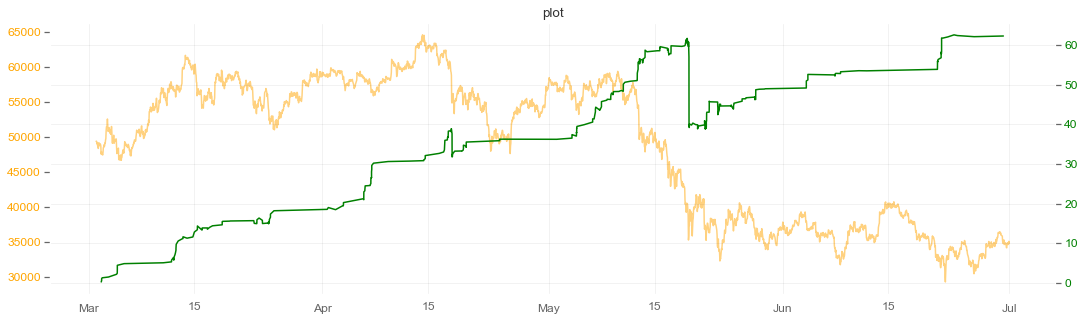

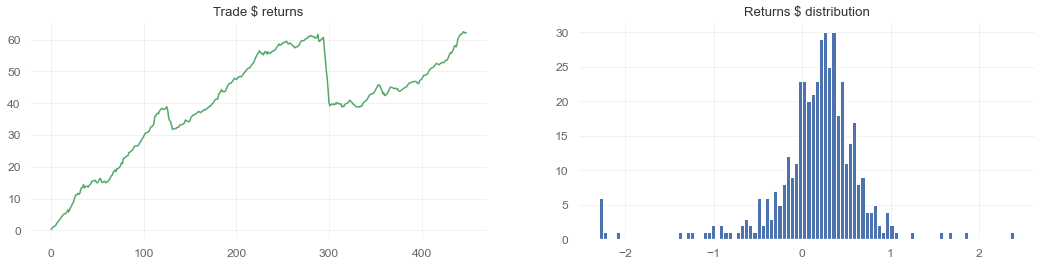

,Portfolio Summary
Trades,449
Avg. Stake Amount,15.0
Number of Pairs,55
Min Balance,0.29
Max Balance,62.5
Final Balance,62.21
-,-
Wins,330
Loses,119
Win Rate,73.0%


freqtrade.nbtools.remote_utils - Adding new row to table...
freqtrade.nbtools.remote_utils - Columns are not identical.
freqtrade.nbtools.remote_utils - New columns    : []
freqtrade.nbtools.remote_utils - Removed columns: ['daily_profit', 'pairlist']
freqtrade.nbtools.remote_utils - Inserting 'None' to removed columns
freqtrade.nbtools.backtest - ===============================
freqtrade.nbtools.backtest - |  'ml_opt_15n30-catboost_l3__backtest-2021-09-03_13-33-22'
freqtrade.nbtools.backtest - |  WANDB LOG PRESET FINISHED  
freqtrade.nbtools.backtest - ===============================


In [13]:
stats, summary, preset = start_backtesting(opt_strategy, MODEL_NAME, "opt", version=MODEL_VER)
trades = pd.DataFrame(stats["strategy"]["NotebookStrategy"]["trades"])
plotting.plot_profits_timerange(trades, timerange=preset.timerange, path_mount=PATH_MOUNT)

# Unbiased Backtesting

You are using LATEST (v0) of '15n30-catboost_l2'
freqtrade.nbtools.remote_utils - Load LightningContainer version 'v0' of project: '15n30-catboost_l2' - asset_name: '15n30-catboost_l2'.
freqtrade.nbtools.preset.base_preset - Overwriting pairs (from 0 to 61 pairs)
freqtrade.nbtools.preset.base_preset - Overwriting pairs (from 0 to 61 pairs)
freqtrade.nbtools.preset.base_preset - Setting config for ml_test_15n30-catboost_l2 ...
freqtrade.nbtools.preset.base_preset - Setting arg `datadir` to c:\CS\Python\crypto-collection\freqtrade\mount\data\binance
freqtrade.nbtools.preset.base_preset - Setting arg `timerange` to 20210622-20210820
freqtrade.nbtools.remote_utils - Load LightningContainer version 'v0' of project: '15n30-catboost_l2' - asset_name: '15n30-catboost_l2'.
freqtrade.nbtools.helper - Strategy using minimal_roi: {'30': -99}
freqtrade.nbtools.helper - Strategy using timeframe: 15m
freqtrade.nbtools.helper - Strategy using stoploss: -0.99
freqtrade.nbtools.helper - Strategy using t

Populating Indicators:   0%|          | 0/60 [00:00<?, ?it/s]

freqtrade.nbtools.helper - "Backtest" executed in 9.56s
freqtrade.nbtools.backtest - Logging preset...
freqtrade.nbtools.backtest - [LOG PRESET OFFLINE SUCCESS]
freqtrade.nbtools.backtest - Sync preset with name: ml_test_15n30-catboost_l2__backtest-2021-09-02_16-30-33
freqtrade.nbtools.backtest - with random name: smart-spiderman-cable
freqtrade.nbtools.backtest - [WANDB LOG PRESET CONTINUES IN BACKGROUND]
freqtrade.nbtools.helper - "Whole Backtesting Process (Backtest + Log)" executed in 20.61s


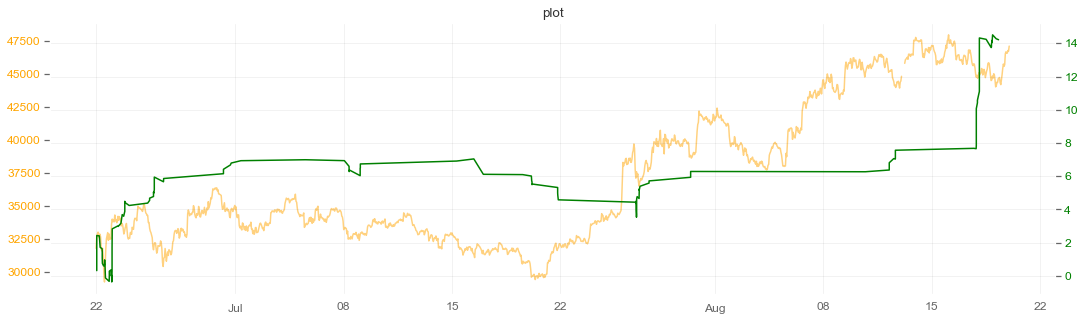

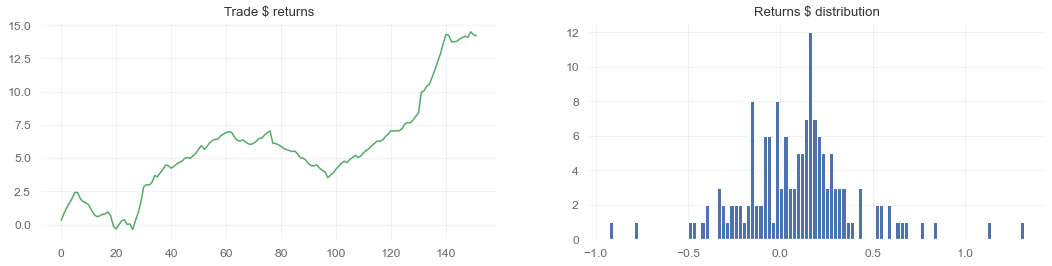

,Portfolio Summary
Trades,152
Min Balance,-0.36857
Max Balance,14.513869
Final Balance,14.219341
Avg. Return (%),0.623032
Avg. Trade Duration,0 days 00:31:58
Wins,96
Loses,56
Win Rate,0.63


freqtrade.nbtools.remote_utils - Adding new row to table...
freqtrade.nbtools.remote_utils - Columns are not identical.
freqtrade.nbtools.remote_utils - New columns    : []
freqtrade.nbtools.remote_utils - Removed columns: ['daily_profit', 'pairlist']
freqtrade.nbtools.remote_utils - Inserting 'None' to removed columns
freqtrade.nbtools.backtest - ===============================
freqtrade.nbtools.backtest - |  'ml_test_15n30-catboost_l2__backtest-2021-09-02_16-30-33'
freqtrade.nbtools.backtest - |  WANDB LOG PRESET FINISHED  
freqtrade.nbtools.backtest - ===============================


In [25]:
""" Just run once every "Sweet Spot" you got from Model x Strategy Optimize!"""
stats, summary, preset = start_backtesting(opt_strategy, MODEL_NAME, "test", version=MODEL_VER)
trades = pd.DataFrame(stats["strategy"]["NotebookStrategy"]["trades"])
plotting.plot_profits_timerange(trades, timerange=preset.timerange, path_mount=PATH_MOUNT)